# Analysis of methods' performance on the DREAM challenge data
The objective of this notebook is to analyze the performance of the tested methods on the DREAM challenge data.


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
import pandas as pd
import os
from statsmodels.stats.multitest import multipletests
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
import collections
from scipy.stats import chi2_contingency
from lifelines import CoxPHFitter
from pathlib import Path

pd.options.display.max_columns = 200
os.chdir('..')
output_path = '20200515_paper_figures/DREAM_results'
Path(output_path).mkdir(parents=True, exist_ok=True)
import warnings
warnings.filterwarnings("ignore")


Bad key "text.kerning_factor" on line 4 in
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
clonesig_res = pd.read_csv('20200525_dream_results.csv', sep='\t')
clonesig_res = clonesig_res[~((clonesig_res.method=='tracksigfreq')&(clonesig_res.nb_mut<100))]
clonesig_res['setting'] = clonesig_res['setting'].fillna("all")
clonesig_res = clonesig_res.assign(full_method=clonesig_res.method + '-' + clonesig_res.setting)
clonesig_res_ith = clonesig_res[clonesig_res.method.isin(['ccube', 'clonesig', 'sciclone', 'tracksig', 'palimpsest', 'dpclust', 'phylogicndt', 'tracksigfreq'])]
clonesig_res_sig = clonesig_res[clonesig_res.method.isin(['clonesig', 'deconstructsigs', 'tracksig', 'palimpsest', 'tracksigfreq'])]

In [4]:
method_color_dict = {'ccube': '#548ebb', 'clonesig': '#fc9d53',
                     'deconstructsigs':'#793d66', 'palimpsest':'#e45683',
                     'pyclone': '#87d0bd', 'sciclone': '#e1f5aa',
                     'tracksig': '#c4c3f9', 'dpclust': '#90c9e8',
                    'phylogicndt': '#F3BEDF', 'tracksigfreq': '#8942fc'}
legend_keys = {'ccube': 'Ccube', 'tracksig': 'TrackSig',
               'tracksigfreq': 'TrackSigFreq', 'pyclone': 'PyClone',
               'sciclone': 'SciClone', 'palimpsest': 'Palimpsest',
               'deconstructsigs': 'deconstructSigs',
               'phylogicndt': 'PhylogicNDT', 'dpclust': 'DPClust',
               'clonesig': 'CloneSig'}

In [5]:
clonesig_res.head()

,tumor,depth,nb_mut,true_nb_clones,true_purity,perc_dip,fitted_nb_clones,ll_ratio,pval,score1B,score1C,score2A,score2C_auc,score2C_accuracy,score2C_sensitivity,score2C_specificity,score2C_precision,score_sig_1A,score_sig_1B,score_sig_1C_auc,score_sig_1C_accuracy,score_sig_1C_sensitivity,score_sig_1C_specificity,score_sig_1C_precision,min_diff_distrib_mut,max_diff_distrib_mut,std_diff_distrib_mut,median_diff_distrib_mut,perc_dist_5,perc_dist_10,runtime,method,setting,full_method
0,T2,8X,578,3,0.55,0.837177,7.0,NaN,NaN,0.0,0.922483,0.029575,0.510062,0.790861,0.044248,0.975877,0.044248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,916.0,pyclone,all,pyclone-all
1,T2,8X,578,3,0.55,0.837177,5.0,NaN,NaN,0.5,0.505273,0.025203,0.498865,0.202109,0.991150,0.006579,0.991150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,sciclone,all,sciclone-all
2,T2,8X,578,3,0.55,0.837177,1.0,NaN,NaN,0.5,0.916703,0.038867,0.500000,0.801406,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,177.0,ccube,all,ccube-all
3,T2,8X,578,3,0.55,0.837177,1.0,NaN,NaN,0.5,0.912720,0.038867,0.500000,0.801406,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,354.0,dpclust,all,dpclust-all
4,T2,8X,578,3,0.55,0.837177,1.0,NaN,NaN,0.5,0.916703,0.038867,0.500000,0.801406,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,178.0,phylogicndt,all,phylogicndt-all


In [6]:
methods_to_use = ['deconstructsigs-cancertype', 'clonesig-cancertype',
                  'palimpsest-cancertype', 'ccube-all', 'sciclone-all',
                  'pyclone-all', 'tracksig-cancertype', 'dpclust-all',
                  'phylogicndt-all', 'tracksigfreq-cancertype']

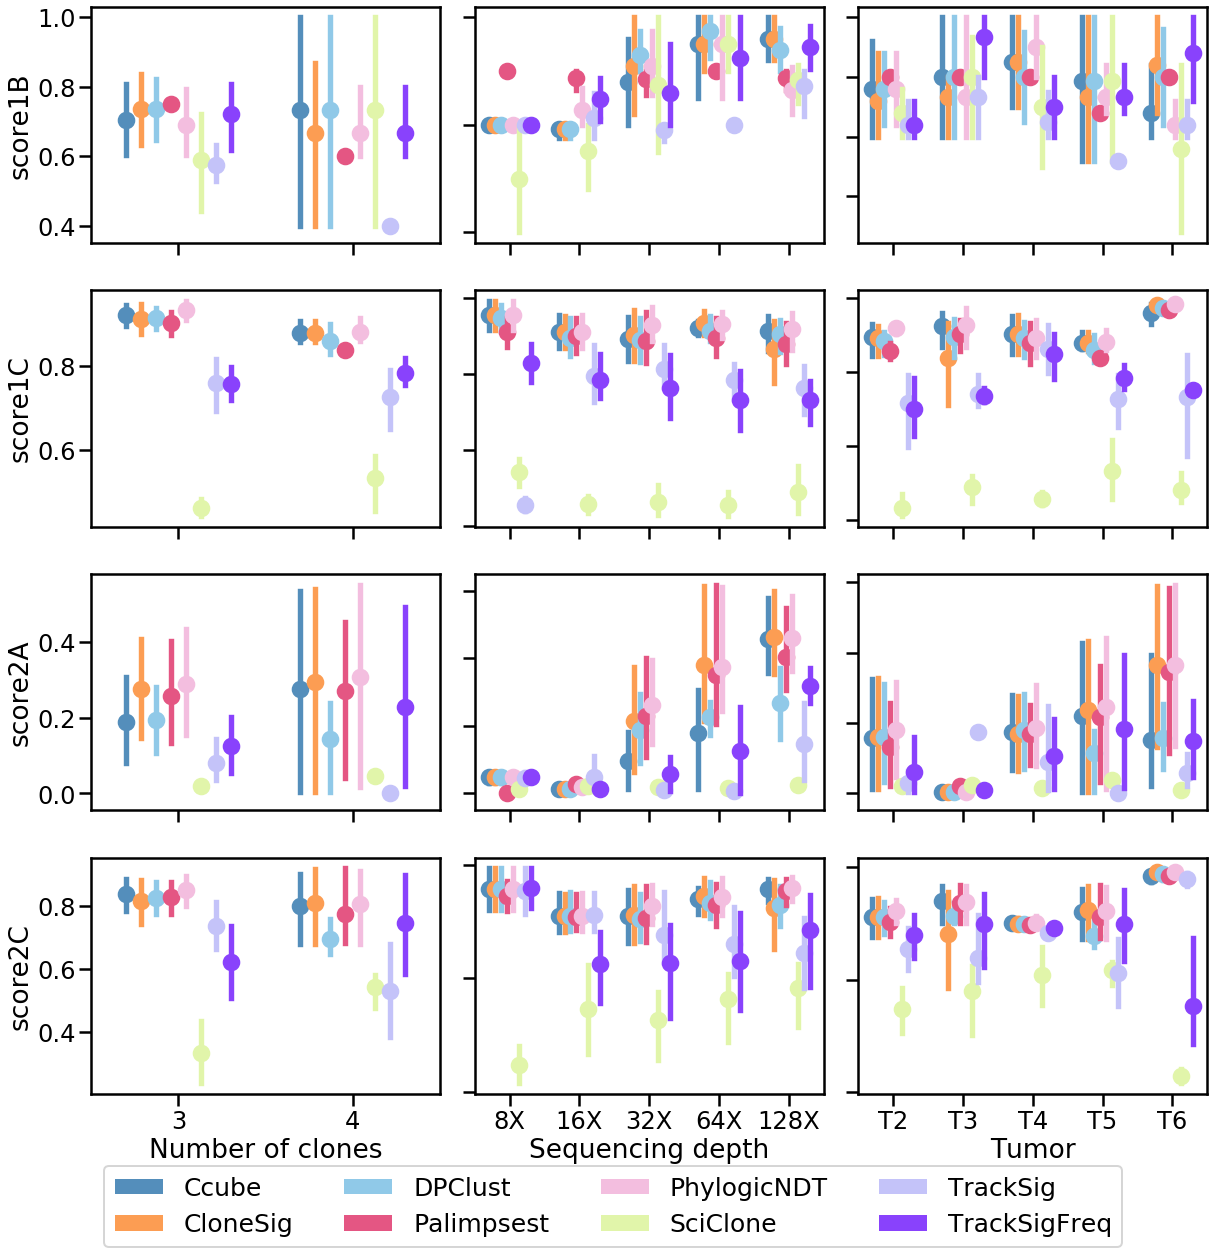

In [7]:
sns.set_context('poster', font_scale=1.1)
id_vars = ['tumor', 'depth']
sub_clonesig_res_ith = clonesig_res_ith[clonesig_res_ith.full_method.isin(methods_to_use)]
nice_name = ['Number of clones', 'Sequencing depth', 'Tumor']
f, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
sub_clonesig_res_ith = sub_clonesig_res_ith.assign(score2C=sub_clonesig_res_ith.score2C_accuracy)
count_dict = dict()
for ii, score in enumerate(['score1B', 'score1C', 'score2A', 'score2C']):
    count_dict[score] = list()
    aa = sub_clonesig_res_ith.dropna(subset=[score]).groupby(id_vars).method.nunique().to_frame().reset_index()
    aa = aa.assign(nb_method=aa.method).drop(columns=['method'])
    sub_clonesig_res_complete = pd.merge(sub_clonesig_res_ith, aa,
                                         on=id_vars)
    sub_clonesig_res_filter = sub_clonesig_res_complete[sub_clonesig_res_complete.nb_method==8]


    for jj, var in enumerate(['true_nb_clones', 'depth', 'tumor']):
        count_dict[score].append(sub_clonesig_res_filter[sub_clonesig_res_filter.method=='clonesig'].groupby(var)[score].count())
        sns.pointplot(x=var, y=score, hue="full_method",
                        data=sub_clonesig_res_filter,
                        hue_order=sorted(sub_clonesig_res_filter.full_method.unique()),
                       palette=[method_color_dict[i.split('-')[0]] for i in sorted(sub_clonesig_res_filter.full_method.unique())],
                         jitter=True, ax=axes[ii, jj], size=10, join=False, dodge=0.6)
        ax = axes[ii, jj]
        if (ii==3) and (jj==0):
            legend_items = list()
            for key in sorted(sorted(sub_clonesig_res_filter.method.unique())):
                legend_items.append(Patch(facecolor=method_color_dict[key], edgecolor='white', label=legend_keys[key]))
            ax.legend(handles=legend_items,
                      bbox_to_anchor=(0, -0.7, 1., .102), fontsize=25, loc=3, ncol=4)
        else:
            ax.get_legend().remove()

        if jj!=0:
            ax.set_ylabel('')
            ax.yaxis.set_ticklabels([])
        if ii!=3:
            ax.set_xlabel('')
            ax.xaxis.set_ticklabels([])
        else:
            ax.set_xlabel(nice_name[jj])
plt.subplots_adjust(wspace=0.1)
plt.savefig('{}/all_comp_method_results_ith_only.pdf'.format(output_path), bbox_inches='tight')



In [8]:
pd.concat([pd.concat(count_dict[s]) for s in ['score1B', 'score1C', 'score2A', 'score2C']], axis=1)

,score1B,score1C,score2A,score2C
3,17,17,15,17
4,3,3,3,3
128X,5,5,4,5
16X,5,5,5,5
32X,4,4,4,4
64X,4,4,3,4
8X,2,2,2,2
T2,5,5,5,5
T3,3,3,1,3
T4,4,4,4,4


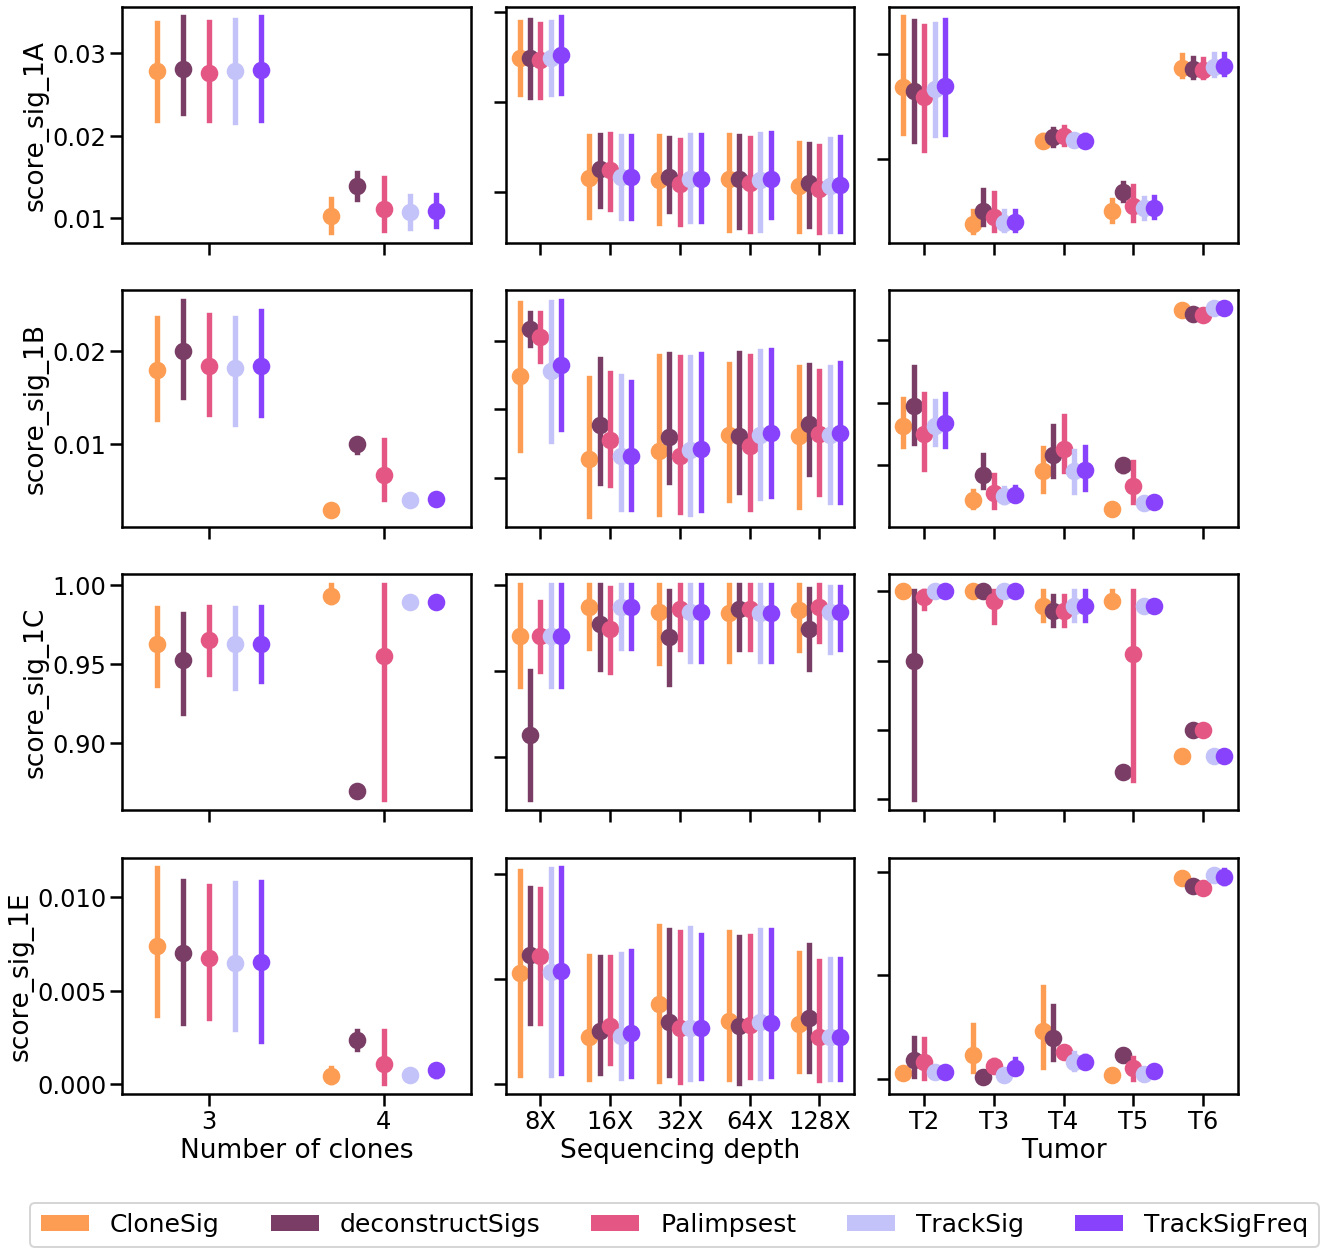

In [9]:
sns.set_context('poster', font_scale=1.1)
id_vars = ['tumor', 'depth']
sub_clonesig_res_sig = clonesig_res_sig[clonesig_res_sig.full_method.isin(methods_to_use)]
aa = sub_clonesig_res_sig.dropna(subset=['score_sig_1A']).groupby(id_vars).method.nunique().to_frame().reset_index()
aa = aa.assign(nb_method=aa.method).drop(columns=['method'])
sub_clonesig_res_complete = pd.merge(sub_clonesig_res_sig, aa,
                                     on=id_vars)
sub_clonesig_res_filter = sub_clonesig_res_complete[sub_clonesig_res_complete.nb_method==5]
sub_clonesig_res_filter = sub_clonesig_res_filter.assign(score_sig_1E=sub_clonesig_res_filter.median_diff_distrib_mut)
sub_clonesig_res_filter = sub_clonesig_res_filter.assign(score_sig_1C=sub_clonesig_res_filter.score_sig_1C_auc)

nice_name = ['Number of clones', 'Sequencing depth', 'Tumor']
f, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
count_dict = dict()
for ii, score in enumerate(('score_sig_1A', 'score_sig_1B',
                            'score_sig_1C', 'score_sig_1E')):
    count_dict[score] = list()
    for jj, var in enumerate(['true_nb_clones', 'depth', 'tumor']):
        count_dict[score].append(sub_clonesig_res_filter[sub_clonesig_res_filter.method=='clonesig'].groupby(var)[score].count())
        sns.pointplot(x=var, y=score, hue="full_method",
                        data=sub_clonesig_res_filter,
                        hue_order=sorted(sub_clonesig_res_filter.full_method.unique()),
                       palette=[method_color_dict[i.split('-')[0]] for i in sorted(sub_clonesig_res_filter.full_method.unique())],
                         jitter=True, ax=axes[ii, jj], size=10, join=False, dodge=0.6)
        ax = axes[ii, jj]
        if (ii==3) and (jj==0):
            legend_items = list()
            for key in sorted(sorted(sub_clonesig_res_filter.method.unique())):
                legend_items.append(Patch(facecolor=method_color_dict[key], edgecolor='white', label=legend_keys[key]))
            ax.legend(handles=legend_items,
                      bbox_to_anchor=(-0.3, -0.7, 1., .102), fontsize=25, loc=3, ncol=5)
        else:
            ax.get_legend().remove()

        if jj!=0:
            ax.set_ylabel('')
            ax.yaxis.set_ticklabels([])
        if ii!=3:
            ax.set_xlabel('')
            ax.xaxis.set_ticklabels([])
        else:
            ax.set_xlabel(nice_name[jj])
plt.subplots_adjust(wspace=0.1)
plt.savefig('{}/all_comp_method_results_sig_only.pdf'.format(output_path), bbox_inches='tight')



In [10]:
pd.concat([pd.concat(count_dict[s]) for s in ('score_sig_1A', 'score_sig_1B',
                            'score_sig_1C', 'score_sig_1E')], axis=1)

,score_sig_1A,score_sig_1B,score_sig_1C,score_sig_1E
3,17,17,17,17
4,3,3,3,3
128X,5,5,5,5
16X,5,5,5,5
32X,4,4,4,4
64X,4,4,4,4
8X,2,2,2,2
T2,5,5,5,5
T3,3,3,3,3
T4,4,4,4,4


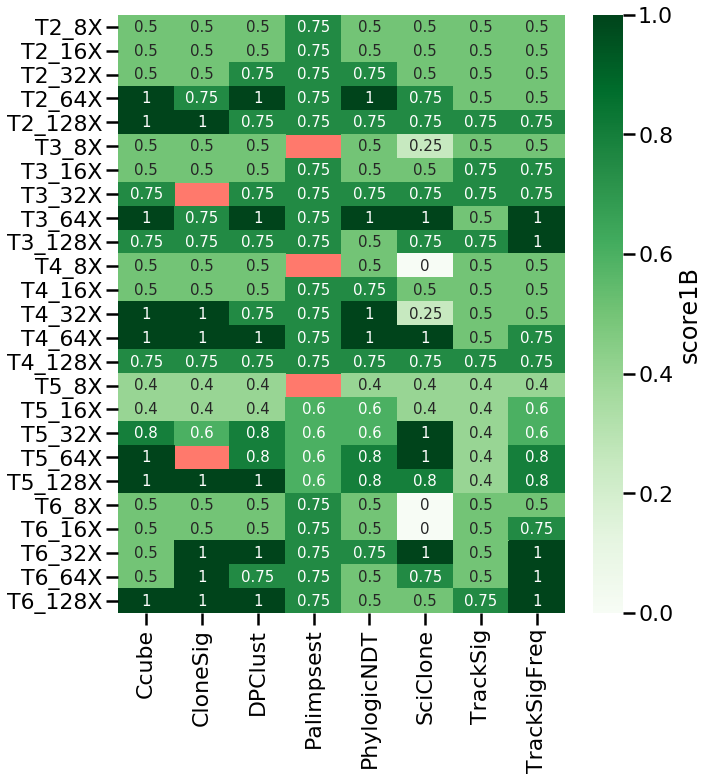

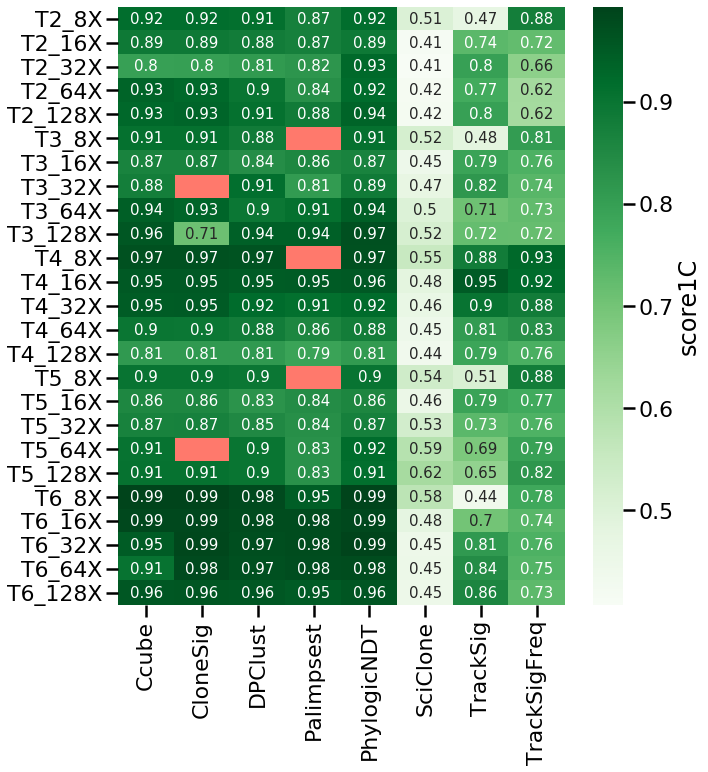

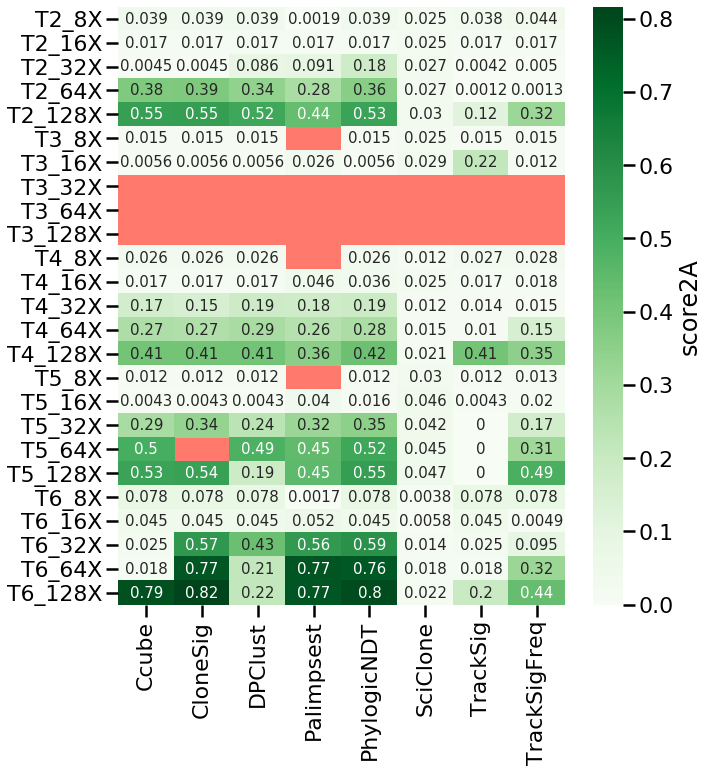

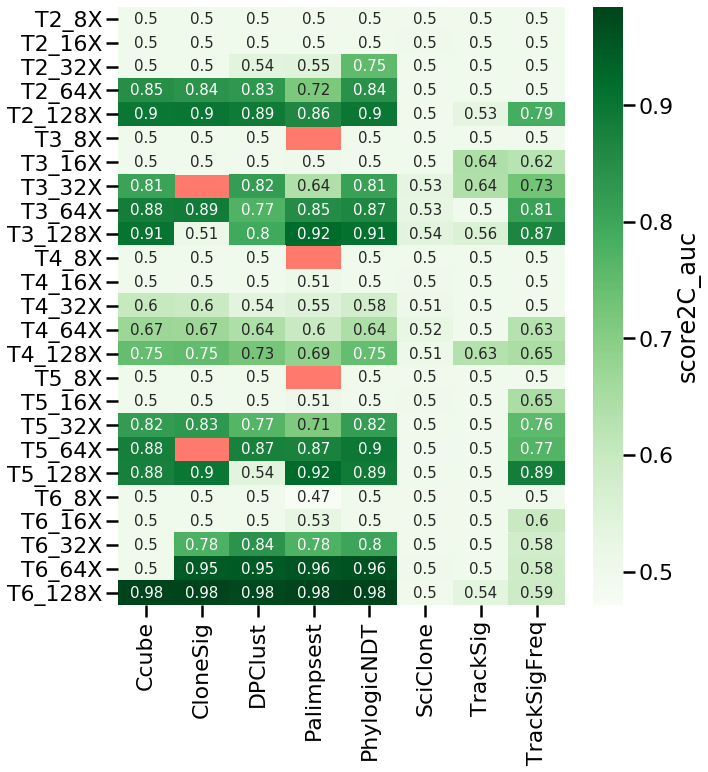

In [11]:
sns.set_context('poster')
for score in ['score1B', 'score1C', 'score2A', 'score2C_auc']:
    sub_clonesig_res_ith = clonesig_res_ith[clonesig_res_ith.full_method.isin(methods_to_use)]
    sub_clonesig_res_ith = sub_clonesig_res_ith.assign(tumor_id=sub_clonesig_res_ith.tumor + "_" + sub_clonesig_res_ith.depth)
    uu=sub_clonesig_res_ith.pivot_table(index='tumor_id', columns=['method'], values=score, aggfunc='mean')
    uu.columns = [legend_keys[c] for c in uu.columns]
    tumor_order = ['T{}_{}X'.format(t, d) for t in range(2, 7) for d in [8, 16, 32, 64, 128]]
    f, ax= plt.subplots(figsize=(10,11))
    sns.heatmap(uu.loc[tumor_order], ax=ax, cmap='Greens', annot=True, annot_kws={'fontsize': 15}, cbar_kws={'label': score})
    ax.set_facecolor('xkcd:salmon')
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.savefig('{}/all_comp_method_results_{}.pdf'.format(output_path, score), bbox_inches='tight')


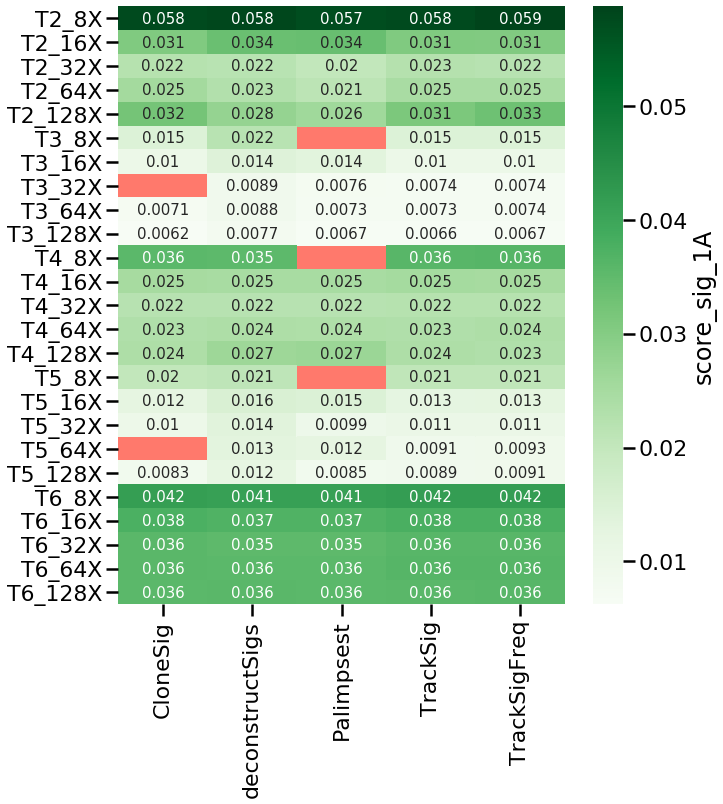

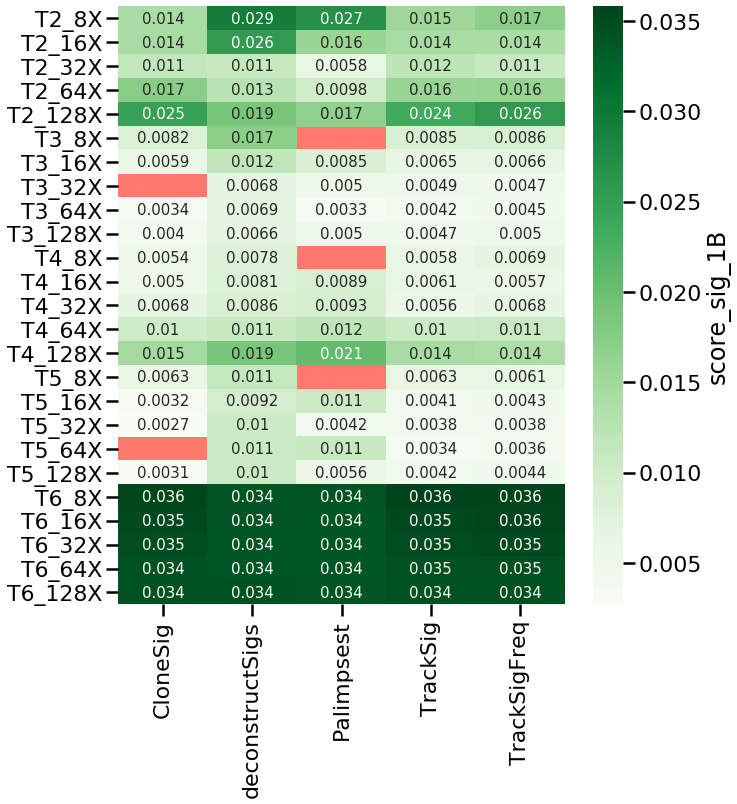

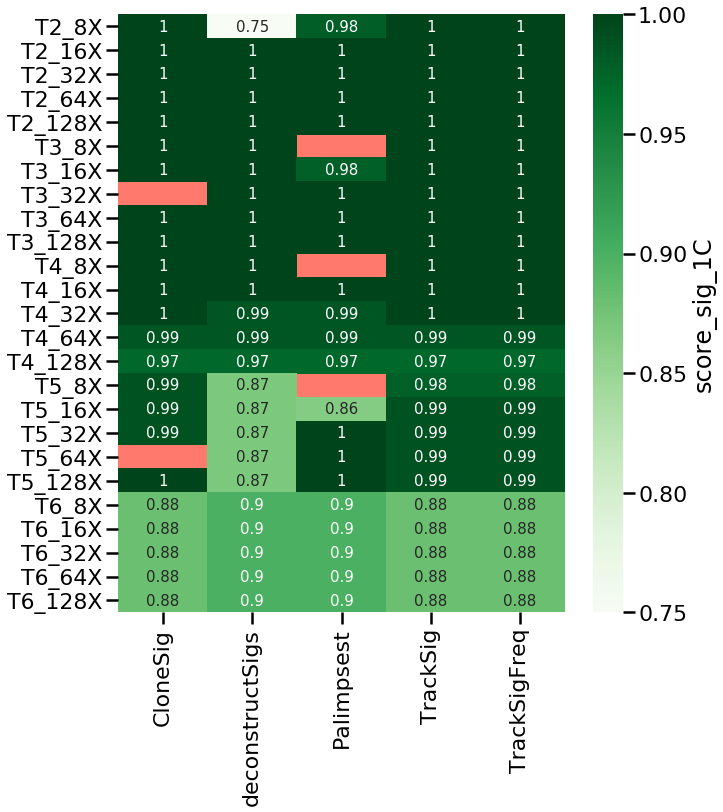

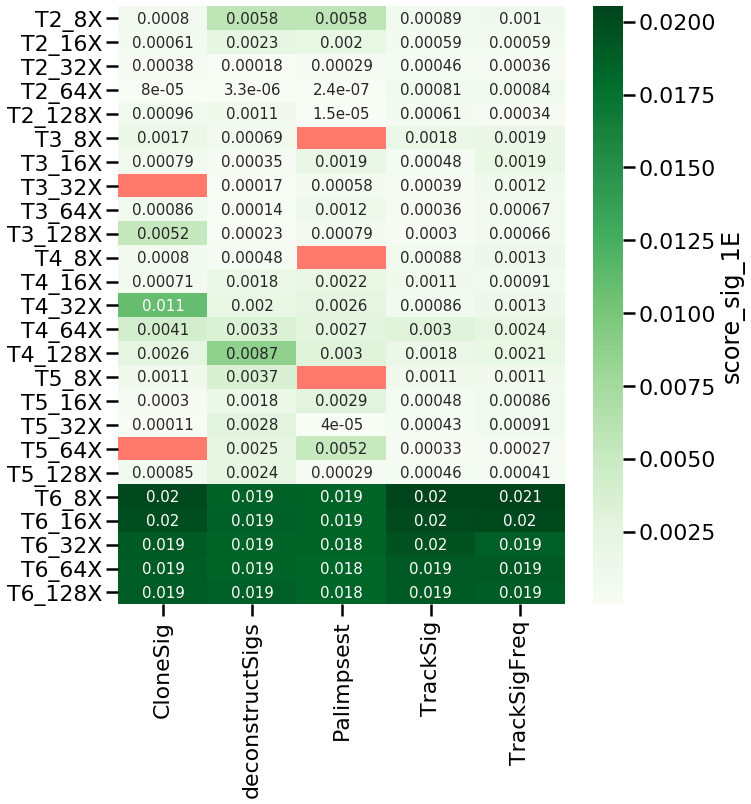

In [12]:
sns.set_context('poster')
sub_clonesig_res_sig = sub_clonesig_res_sig.assign(score_sig_1E=sub_clonesig_res_sig.median_diff_distrib_mut)
sub_clonesig_res_sig = sub_clonesig_res_sig.assign(score_sig_1C=sub_clonesig_res_sig.score_sig_1C_auc)
for score in ('score_sig_1A', 'score_sig_1B', 'score_sig_1C', 'score_sig_1E'):
    sub_clonesig_res_sig = sub_clonesig_res_sig[sub_clonesig_res_sig.full_method.isin(methods_to_use)]
    sub_clonesig_res_sig = sub_clonesig_res_sig.assign(tumor_id=sub_clonesig_res_sig.tumor + "_" + sub_clonesig_res_sig.depth)
    
    uu=sub_clonesig_res_sig.pivot_table(index='tumor_id', columns=['method'], values=score, aggfunc='mean')
    uu.columns = [legend_keys[c] for c in uu.columns]
    tumor_order = ['T{}_{}X'.format(t, d) for t in range(2, 7) for d in [8, 16, 32, 64, 128]]
    f, ax= plt.subplots(figsize=(10,11))
    sns.heatmap(uu.loc[tumor_order], ax=ax, cmap='Greens', annot=True, annot_kws={'fontsize': 15}, cbar_kws={'label': score})
    ax.set_facecolor('xkcd:salmon')
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.savefig('{}/all_comp_method_results_{}.pdf'.format(output_path, score), bbox_inches='tight')
